In [67]:
import bisect
import sys
from test_functions import test_functions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
rec = 100000
sys.setrecursionlimit(rec)

In [82]:
def F(f, fdot, dots, x, g_max_index):
    new_index = bisect.bisect_right(dots[: -1], [x, float("inf"), 0, 0])
    a, b = dots[new_index - 1][0], dots[new_index][0]
    m = dots[g_max_index][3] * tau
    phi_1 = f(a) + fdot(a) * (x - a) - 0.5 * m *(x - a) ** 2
    phi_2 = f(b) - fdot(b) * (b - x) - 0.5 * m * (b - x) ** 2
    return max(phi_1, phi_2)

In [83]:
def g_ed(f, fdot, b, a):
    g_1 = abs(fdot(b) - fdot(a)) / (b - a)
    g_2 = ((-f(b) + f(a) + fdot(a) * (b - a)) / ((b - a) ** 2)) * 2
    g_3 = ((f(b) - f(a) - fdot(b) * (b - a)) / ((b - a) ** 2)) * 2
    g = max(g_1, g_2, g_3)
    return g

In [84]:
def x_cupped(f, fdot, b, a, m):
    x_cup = (-f(b) + f(a) + fdot(b) * b - fdot(a) * a + 0.5 * m * (b * b - a * a)) / (m * (b - a) + fdot(b) - fdot(a))
    return x_cup

In [85]:
def charred(f, fdot, a, m, xc):
    return f(a) + fdot(a) * (xc - a) - 0.5 * m * (xc - a) ** 2


In [86]:
def dgn(f, dots, fdot, counter, g_max_index):

    min_value, min_index, x_cup = min([(y, i, xc) for i, (_, y, xc, _) in enumerate(dots)])
    g_max_start = dots[g_max_index][3]

    if abs(dots[min_index][0] - dots[min_index + 1][0]) < epsilon:
        func_values = [f(x) for (x, _, _, _) in dots]
        return min(func_values), counter, g_max_index


    counter += 1

    new_index = bisect.bisect_left(dots, [x_cup, -float("inf"), 0, 0])
    bisect.insort_left(dots, [x_cup, -float("inf"), 0, 0, 0])


    g1 = g_ed(f, fdot, dots[new_index][0], dots[new_index - 1][0])
    g2 = g_ed(f, fdot, dots[new_index + 1][0], dots[new_index][0])

    dots[new_index - 1] = [dots[new_index - 1][0], None, None, g1]
    dots[new_index] = [dots[new_index][0], None, None, g2]

    g_max_value, g_max_index = max([(g, -i) for i, (_, _, _, g) in enumerate(dots)])
    g_max_index *= (-1)
    m = tau * g_max_value

    if g_max_value != g_max_start:

        for index, dot in enumerate(dots[:-1]):
            x_cup_i = x_cupped(f, fdot, dots[index + 1][0], dots[index][0], m)
            char_i = charred(f, fdot, dots[index][0], m, x_cup_i)
            dots[index] = [dot[0], char_i, x_cup_i, dot[3]]

    else:

        x_cup_1 = x_cupped(f, fdot, dots[new_index][0], dots[new_index - 1][0], m)
        x_cup_2 = x_cupped(f, fdot, dots[new_index + 1][0], dots[new_index][0], m)
        char_1 = charred(f, fdot, dots[new_index - 1][0], m, x_cup_1)
        char_2 = charred(f, fdot, dots[new_index][0], m, x_cup_2)

        dots[new_index - 1] = [dots[new_index - 1][0], char_1, x_cup_1, g1]
        dots[new_index] = [dots[new_index][0], char_2, x_cup_2, g2]

    return dgn(f, dots, fdot, counter, g_max_index)

In [87]:
tau = 1.1

In [88]:
xarrays, yarrays, ogarrays = [], [], []
for index, func in enumerate(test_functions):
    x_arr = np.linspace(func.interval[0], func.interval[1], 1200)
    y = []
    og = []
    f, fdot, a, b, L, counter = func.f, func.fdot, func.interval[0], func.interval[1], func.L, 0
    epsilon = (b - a) * (10 ** -4)
    g = g_ed(f, fdot, b, a)
    m = 1 if g == 0 else tau * g
    x_cup = x_cupped(f, fdot, b, a, m)
    char = charred(f, fdot, a, m, x_cup)
    dots  = [[a, char, x_cup, g], [b, float("inf"), None, -float("inf")]]
    minval, count, g_max_ind = dgn(f, dots, fdot, counter, 0)
    print(index + 1, minval, count)
    for i in x_arr:
        y.append(f(i))
        og.append(F(f, fdot, dots, i, g_max_ind))
    xarrays.append(x_arr)
    yarrays.append(y)
    ogarrays.append(og)

1 -29763.233314888028 23
2 -1.899599292849388 23
3 -12.031229046433255 83
4 -3.850450707604645 24
5 -1.4890724535591928 25
6 -0.8242391622761591 38
7 -1.6013075440273772 23
8 -14.507978022359806 84
9 -1.905960895816472 21
10 -7.916727336228301 20
11 -1.4999999932445711 38
12 -0.9999999659951582 36
13 -1.5874010511696692 81
14 -0.788685253678697 28
15 -0.035533901014565224 39
16 7.515924373341307 68
17 7.000003218116518 63
18 1.4849538362052007e-08 22
19 -7.815674510592856 21
20 -0.0634905018389729 38


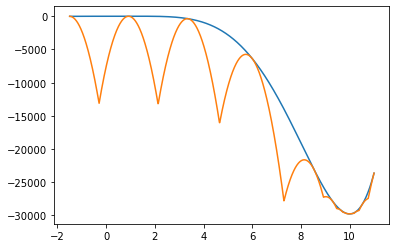

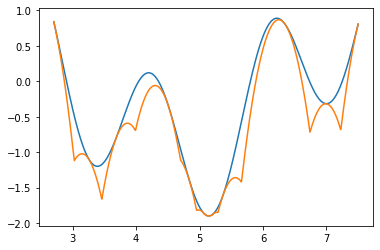

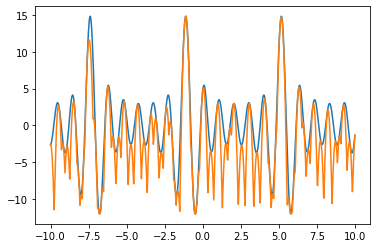

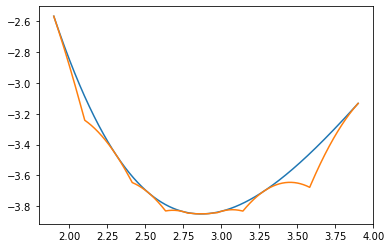

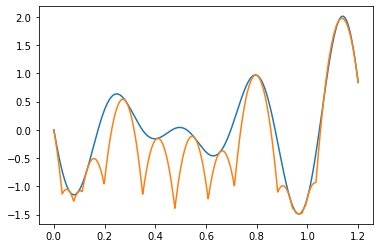

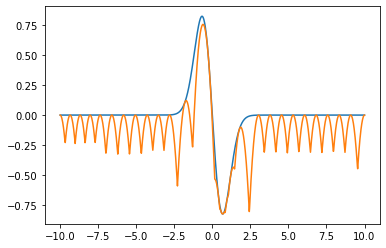

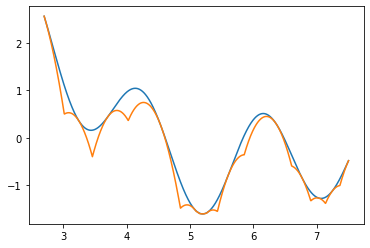

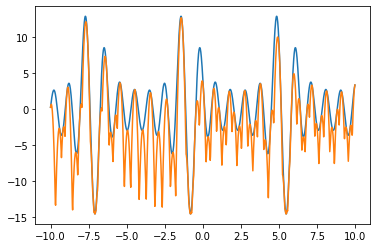

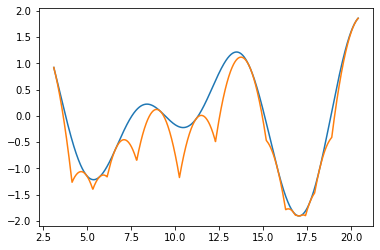

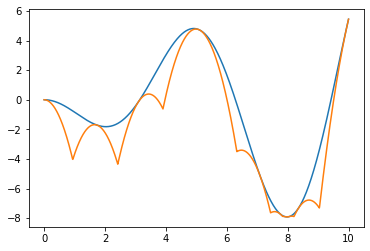

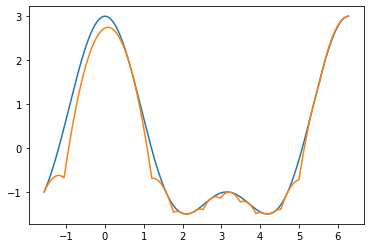

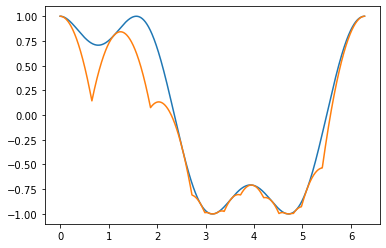

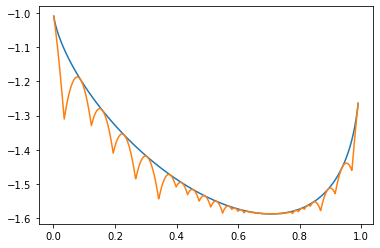

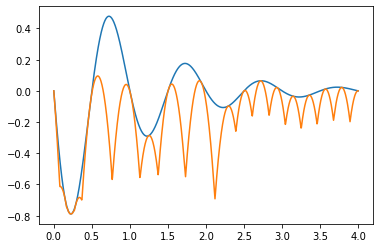

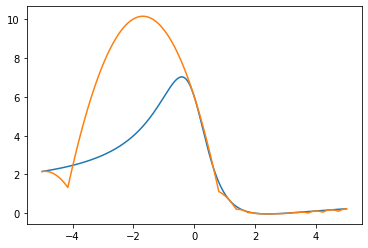

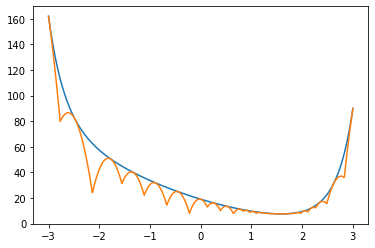

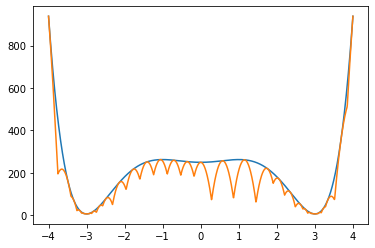

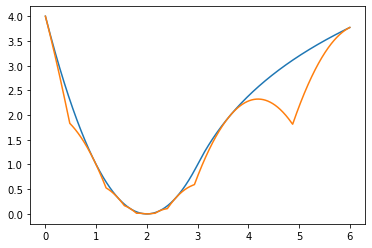

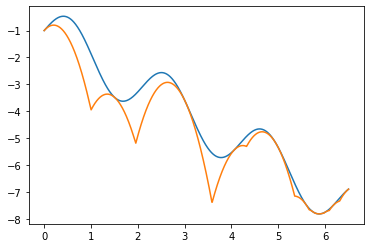

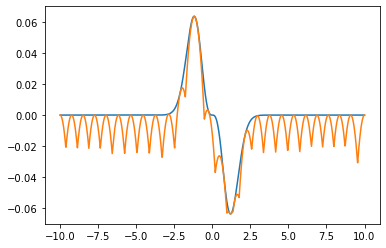

In [89]:
 for index in range(20):
    plt.plot(xarrays[index], yarrays[index])
    plt.plot(xarrays[index], ogarrays[index])
    plt.show()